https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [2]:

import os
import argparse
import torch as th
import torch.nn.functional as F
import time
import conf_mgt
from utils import yamlread
from guided_diffusion import dist_util
from tqdm import tqdm
# Workaround
try:
    import ctypes
    libgcc_s = ctypes.CDLL('libgcc_s.so.1')
except:
    pass


from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    select_args,
)  # noqa: E402

from guided_diffusion.script_util import (
    sr_model_and_diffusion_defaults,
    sr_create_model_and_diffusion,
)
def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample

import torch
import torchvision.transforms as T

In [3]:
intermediate_steps = False #return intermediate results (usefull to create gifs)
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread('confs/my_conf-2_cond.yml'))
print(conf.inpa_inj_sched_prev) #Are you about to use RePainting ?print(conf.diffusion_steps) #may not be the good one
conf.intermediate_steps = intermediate_steps
print(conf.intermediate_steps)


True
False


In [6]:
conf['schedule_jump_params']['jump_n_sample'] = 20


In [7]:
print("Start", conf['name'])

device = dist_util.dev(conf.get('device'))


model, diffusion = create_model_and_diffusion(
    **select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)


Start my_conf


In [8]:
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
model.to(device)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()

show_progress = conf.show_progress

import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Nombre de paramètres : ', params)

Nombre de paramètres :  553838086


In [ ]:
# https://colab.research.google.com/drive/12a_Wrfi2_gwwAuN3VvMTwVMz9TfqctNj#scrollTo=7zAqFEykBHDL TO DO

In [9]:

if conf.classifier_scale is not None:
    if conf.classifier_scale > 0 and conf.classifier_path:
        print("loading classifier...")
        classifier = create_classifier(
            **select_args(conf, classifier_defaults().keys()))
        classifier.load_state_dict(
            dist_util.load_state_dict(os.path.expanduser(
                conf.classifier_path), map_location="cpu")
        )

        classifier.to(device)
        if conf.classifier_use_fp16:
            classifier.convert_to_fp16()
        classifier.eval()

        def cond_fn(x, t, y=None, gt=None, **kwargs):
            assert y is not None
            with th.enable_grad():
                x_in = x.detach().requires_grad_(True)
                logits = classifier(x_in, t)
                log_probs = F.log_softmax(logits, dim=-1)
                selected = log_probs[range(len(logits)), y.view(-1)]
                return th.autograd.grad(selected.sum(), x_in)[0] * conf.classifier_scale
else:
    cond_fn = None

def model_fn(x, t, y=None, gt=None, **kwargs):
    assert y is not None # pourquoi ? 
    return model(x, t, y if conf.class_cond else None, gt=gt)

loading classifier...


In [23]:
conf.class_cond

True

In [10]:
def tou8batch(result,return_all=False):
    if return_all:
        finals = result[1]['sample']
    else:
        finals = result
    finals = ((finals + 1) * 127.5).clamp(0, 255).to(th.uint8)
    finals = finals.contiguous()
    return(finals)

In [11]:
dset = 'eval'

eval_name = conf.get_default_eval_name()
GT_PATH = './data/datasets/gts/others'
MASK_PATH = './data/datasets/gt_keep_masks/square'
IMAGE_SIZE = 256

dataconfig = {'mask_loader': True,
 'gt_path': GT_PATH,
 'mask_path': MASK_PATH,
 'image_size': IMAGE_SIZE,
 'class_cond': False,
 'deterministic': True, # Pas de shuffle dans le dataloader
 'random_crop': False, # Crop (au lieu de redimensionner l'image). Non Implémenté.
 'random_flip': False,
 'return_dict': True,
 'drop_last': False,
 'batch_size': 1,
 'return_dataloader': True,
 'offset': 0,
 'max_len': 8,
 'paths': {'srs': './log/face_example/inpainted',
  'lrs': './log/face_example/gt_masked',
  'gts': './log/face_example/gt',
  'gt_keep_masks': './log/face_example/gt_keep_mask'}
             }
return_all = False
conf['data']['eval'][eval_name] = dataconfig
dl = conf.get_dataloader(dset=dset, dsName=eval_name)
transform = T.ToPILImage()

save_path = './inpainted/seashore_500/'
format_save = '.png'

In [12]:
for j in range(11):
        dl = conf.get_dataloader(dset=dset, dsName=eval_name)
        batch = next(iter(dl)) #écrit pour un batch size de 1
        img = batch['GT'].to(device)
        mask = batch['gt_keep_mask'].to(device)
        name = batch['GT_name'][0][:-4] #ici need batch size = 1. Le -4 vise à retirer le format.

        model_kwargs = {}
        model_kwargs["gt"] = img
        model_kwargs['y'] = th.tensor([978], device=device) #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini. # 978 is seashore category
        model_kwargs['gt_keep_mask'] = mask
        model_kwargs['stop_to'] = None
        model_kwargs['starting_point'] = None
        batch_size = model_kwargs['gt'].shape[0]

        sample_fn = (
            diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
        )



        result = sample_fn(
        model_fn,
        (batch_size, 3, conf.image_size, conf.image_size),
        clip_denoised=conf.clip_denoised,
        model_kwargs=model_kwargs,
        cond_fn=cond_fn,
        device=device,
        progress=show_progress,
        return_all=return_all,
        conf=conf
        )

        imgend = transform(tou8batch(result)[0])
        imgend.save(save_path+name+'_'+str(j)+format_save)
        
        del result
        torch.cuda.empty_cache()

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

  0%|          | 0/9370 [00:00<?, ?it/s]

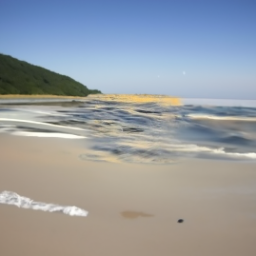

In [ ]:
for j in range(30):
    dl = conf.get_dataloader(dset=dset, dsName=eval_name)
    for batch in iter(dl): #écrit pour un batch size de 1
        img = batch['GT'].to(device)
        mask = batch['gt_keep_mask'].to(device)
        name = batch['GT_name'][0][:-4] #ici need batch size = 1. Le -4 vise à retirer le format.

        img = torch.stack([img[0],img[0]])
        mask = torch.stack([mask[0],mask[0]])
        model_kwargs = {}
        model_kwargs["gt"] = img
        model_kwargs['y'] = 'SALUT LOLOL' #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini.
        model_kwargs['gt_keep_mask'] = mask
        model_kwargs['stop_to'] = None
        model_kwargs['starting_point'] = None
        batch_size = model_kwargs['gt'].shape[0]

        sample_fn = (
            diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
        )


        result = sample_fn(
        model_fn,
        (batch_size, 3, conf.image_size, conf.image_size),
        clip_denoised=conf.clip_denoised,
        model_kwargs=model_kwargs,
        cond_fn=cond_fn,
        device=device,
        progress=show_progress,
        return_all=return_all,
        conf=conf
        )

        img = transform(tou8batch(result)[0]) #ici aussi batch size = 1
        img.save(save_path+name+'_'+str(j)+format_save)
        
        del result
        torch.cuda.empty_cache()

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

In [8]:
img = batch['GT'].to(device)
mask = batch['gt_keep_mask'].to(device)

img = torch.stack([img[0],img[0]])
mask = torch.stack([mask[0],mask[0]])

model_kwargs = {}
model_kwargs["gt"] = img
model_kwargs['y'] = 'SALUT LOLOL' #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini.
model_kwargs['gt_keep_mask'] = mask

batch_size = model_kwargs['gt'].shape[0]

sample_fn = (
    diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
)



In [12]:

!nvidia-smi

Wed Dec 21 16:39:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   27C    P8    12W / 200W |   4985MiB /  8192MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

La configuration du dataset contient notamment les arguments utilisés par la classe ImageDatasetInpa (image_dataset.py dans le dossier guided_diffusion) pour retourner à partir du répertoire des images un dataset pytorch. Ce dataset est converti en dataloader avec la fonction DataLoader dans le même fichier.

Pour créer un dataset ImageDatasetInpa il faut la liste des imagages que l'on souhaite utiliser, et que l'on récupère avec la fonction _list_image_files_recursivcely.

In [10]:
return_all = False
result = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
    device=device,
    progress=show_progress,
    return_all=return_all,
    conf=conf
)


  0%|          | 0/4570 [00:00<?, ?it/s]

In [15]:
result.shape

NameError: name 'result' is not defined

In [17]:
transform = T.ToPILImage()
if return_all:
finals = result[1]
f_samples = finals['sample']
f_samples = ((f_samples + 1) * 127.5).clamp(0, 255).to(th.uint8)
f_samples = f_samples.contiguous()
i=5
for sample in f_samples:
    img = transform(sample)
    img.save("images/sample_"+str(i)+".jpeg")
    i+=1

IndexError: too many indices for tensor of dimension 4

In [13]:
del result
torch.cuda.empty_cache()
!nvidia-smi

Wed Dec 21 16:40:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   27C    P8    10W / 200W |   3212MiB /  8192MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
result[2461].shape

IndexError: list index out of range

In [17]:





if conf.name=='my_conf':
    result = result[1] #0 is all tuples to generate gifs
srs = toU8(result['sample'])
gts = toU8(result['gt'])
lrs = toU8(result.get('gt') * model_kwargs.get('gt_keep_mask') + (-1) *
           th.ones_like(result.get('gt')) * (1 - model_kwargs.get('gt_keep_mask')))

gt_keep_masks = toU8((model_kwargs.get('gt_keep_mask') * 2 - 1))

conf.eval_imswrite(
    srs=srs, gts=gts, lrs=lrs, gt_keep_masks=gt_keep_masks,
    img_names=batch['GT_name'], dset=dset, name=eval_name, verify_same=False)

  0%|          | 0/4570 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
    srs = toU8(result[1]['sample'])
    gts = toU8(result[1]['gt'])
    lrs = toU8(result[1].get('gt') * model_kwargs.get('gt_keep_mask') + (-1) *
               th.ones_like(result[1].get('gt')) * (1 - model_kwargs.get('gt_keep_mask')))

    gt_keep_masks = toU8((model_kwargs.get('gt_keep_mask') * 2 - 1))

    conf.eval_imswrite(
        srs=srs, gts=gts, lrs=lrs, gt_keep_masks=gt_keep_masks,
        img_names=batch['GT_name'], dset=dset, name=eval_name, verify_same=False)

In [24]:
lrs

array([[[[143, 144, 156],
         [140, 142, 154],
         [144, 145, 157],
         ...,
         [104, 120, 130],
         [105, 121, 132],
         [104, 120, 131]],

        [[142, 143, 155],
         [141, 143, 155],
         [142, 143, 155],
         ...,
         [104, 120, 130],
         [102, 118, 129],
         [103, 119, 130]],

        [[142, 144, 156],
         [142, 143, 155],
         [142, 144, 156],
         ...,
         [101, 118, 129],
         [100, 118, 130],
         [103, 120, 131]],

        ...,

        [[153, 127, 116],
         [169, 134, 117],
         [168, 133, 114],
         ...,
         [ 37,  80, 104],
         [ 33,  82, 107],
         [ 31,  84, 111]],

        [[168, 130, 116],
         [173, 132, 117],
         [171, 132, 117],
         ...,
         [ 36,  81, 104],
         [ 33,  83, 107],
         [ 32,  86, 112]],

        [[169, 133, 113],
         [169, 133, 115],
         [167, 128, 113],
         ...,
         [ 35,  82, 104],
        